In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import os
import numpy as np
import cv2
from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
image_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [4]:
data = {'train' : ImageFolder(root = './train', transform = image_transforms),
        'test' : ImageFolder(root = './test', transform = image_transforms),
        'val' : ImageFolder(root = './val', transform = image_transforms)}

In [5]:
data['train'].class_to_idx, data['test'].class_to_idx, data['val'].class_to_idx

({'NORMAL': 0, 'PNEUMONIA': 1},
 {'NORMAL': 0, 'PNEUMONIA': 1},
 {'NORMAL': 0, 'PNEUMONIA': 1})

In [6]:
dataloaders = {'train' : DataLoader(data['train'], batch_size = 100, shuffle = True),
               'test' : DataLoader(data['test'], batch_size = 100, shuffle = True),
               'val' : DataLoader(data['val'], batch_size = 100, shuffle = True)}

In [7]:
model_res18 = models.resnet18(pretrained=True)
model_res18.fc = nn.Linear(model_res18.fc.in_features, 2)

In [8]:
model_res18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
optimizer = optim.Adam(model_res18.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
train_loss = []
val_loss = []

In [10]:
epochs = 2
for epoch in tqdm(range(1,epochs+1)):
    
    # Training Loop
    for image, label in dataloaders['train']:
        image, label = image.to(device), label.to(device)

        model_res18.zero_grad()
        prediction = model_res18(image)
        loss = criterion(prediction, label)
        loss.backward()
        optimizer.step()
    print("EPOCH", epoch)
    print('training_loss: ', loss)
    train_loss.append(loss)
    
    # Evaluation Loop
    model_res18.eval()
    with torch.no_grad():
        for image, label in dataloaders['val']:
            image, label = image.to(device), label.to(device)

            prediction = model_res18(image)
            loss = criterion(prediction, label)
    print('validation_loss: ', loss)
    val_loss.append(loss)
    
    model_res18.train()

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH 1
training_loss:  tensor(0.0206, device='cuda:0', grad_fn=<NllLossBackward>)
validation_loss:  tensor(0.6040, device='cuda:0')
EPOCH 2
training_loss:  tensor(0.0928, device='cuda:0', grad_fn=<NllLossBackward>)
validation_loss:  tensor(0.1005, device='cuda:0')


In [11]:
# Training Loop
correct = 0
total = 0

ground_truth = []
predicted_results = []
model_res18.eval()


with torch.no_grad():
    for image, label in dataloaders['test']:
        image, label = image.to(device), label.to(device)

        prediction = model_res18(image)
        #loss = loss_fun(prediction, label)
        #print(prediction)
        for k in range(len(prediction)):
            #print(k)
            #print(prediction)
            #print(label)
            ground_truth.append(label[k].item())
            predicted_results.append(torch.argmax(prediction[k]).item())
            
            if torch.argmax(prediction[k]) == label[k]:
                correct+=1
                #print(image.shape)
            total += 1

#validation_loss.append(loss)    
#print('validation_loss: ', loss)
print('accuracy: ', round(correct/total, 3))
print('correct ', correct)
print('total', total)

accuracy:  0.814
correct  508
total 624


In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

array([[120, 114],
       [  2, 388]], dtype=int64)

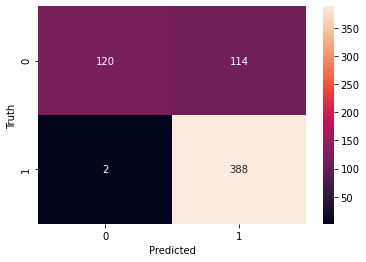

In [13]:
cm = confusion_matrix(ground_truth, predicted_results)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
cm

In [14]:
print(classification_report(ground_truth, predicted_results))

              precision    recall  f1-score   support

           0       0.98      0.51      0.67       234
           1       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.77       624
weighted avg       0.85      0.81      0.80       624

